In [1]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score
import optuna
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

In [2]:
train_df = pd.read_csv('dataset/train_01.csv')
test_df = pd.read_csv('dataset/test_01.csv')

In [3]:
ID = test_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']
test_df = test_df.drop(columns='id')

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=18
                                                   )

# RFC

In [7]:
def objective(trial):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
    
    param_rfc ={      
        'n_estimators': trial.suggest_int('n_estimators', 800, 1500),
        'criterion': trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 15),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 5),
        'random_state': 18,
        'n_jobs': 4
    }
    
    rfc = RandomForestClassifier(**param_rfc)
    scores = cross_validate(rfc, x, y, cv=skf)
    return scores['test_score'].mean()

In [8]:
study_rfc = optuna.create_study(direction='maximize')
study_rfc.optimize(objective, n_trials=100, n_jobs=4)
print(study_rfc.best_params)
print(study_rfc.best_value)
rfc_best_params = study_rfc.best_params

[I 2020-08-08 13:18:01,213] Finished trial#0 resulted in value: 0.929040590405904. Current best value is 0.929040590405904 with parameters: {'n_estimators': 1032, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 5}.
[I 2020-08-08 13:18:27,749] Finished trial#1 resulted in value: 0.9249815498154981. Current best value is 0.929040590405904 with parameters: {'n_estimators': 1032, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 5}.
[I 2020-08-08 13:19:10,397] Finished trial#2 resulted in value: 0.9292250922509225. Current best value is 0.9292250922509225 with parameters: {'n_estimators': 1385, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3}.
[I 2020-08-08 13:19:31,061] Finished trial#3 resulted in value: 0.9243911439114392. Current best value is 0.9292250922509225 with parameters: {'n_estimators': 1385, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3}.
[

{'n_estimators': 1183, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 4}
0.9298523985239854


In [9]:
rfc = RandomForestClassifier(**rfc_best_params)
rfc.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_leaf=4,
                       min_samples_split=13, n_estimators=1183)

In [11]:
train_score_rfc = rfc.score(x_train, y_train)
test_score_rfc = rfc.score(x_test, y_test)

rfc_p = rfc.predict(x_test)

acc_rfc = accuracy_score(rfc_p, y_test)
auc_rfc = roc_auc_score(rfc_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_rfc, test_score_rfc))
print('acc:{}, auc:{}'.format(acc_rfc, auc_rfc))

train score:0.9312071692145493, test_score:0.9302583025830258
acc:0.9302583025830258, auc:0.9220031934033673


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


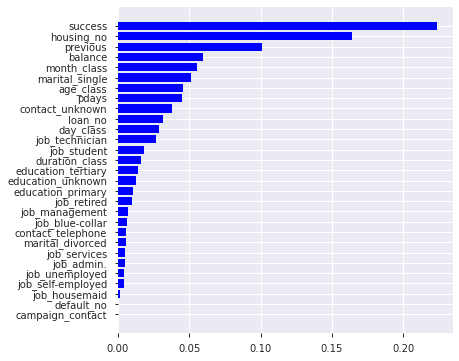

In [12]:
features = x_train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

# XGB

In [ ]:
xgb = xgb.XGBClassifier()
xgb.fit(x_train, y_train)

In [ ]:
train_score_xgb = xgb.score(x_train, y_train)
test_score_xgb = xgb.score(x_test, y_test)

print('train score:{}, test_score:{}'.format(train_score_xgb, test_score_xgb))

# LGB

In [ ]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test)

params_lgb = {
    'objective': 'binary',
    'metric':'auc',
    'num_iterations':1000,
    'eary_stopping': 50,
}

lgb = lgb.train(params_lgb, lgb_train, valid_sets=lgb_eval, verbose_eval=100)

# CB

In [ ]:
params_cab = {
    'iterations':1000,
    'custom_loss':['Accuracy'],
    'early_stopping_rounds':50,
}

In [ ]:
cab = CatBoostClassifier(**params_cab)

cab.fit(x_train, y_train)

In [ ]:
train_score_cab = cab.score(x_train, y_train)
test_score_cab = cab.score(x_test, y_test)

print('train score:{}, test_score:{}'.format(train_score_cab, test_score_cab))

## submit

In [ ]:
pred_rfc = rfc.predict(test_df)
pred_xgb = xgb.predict(test_df)
pred_lgb = lgb.predict(test_df)
pred_cab = cab.predict(test_df)

In [ ]:
pred = pd.DataFrame({
    'RandomForest': pred_rfc,
    'XGBoost': pred_xgb,
    'LigntGBM': pred_lgb,
    'CatBoost': pred_cab
})

pred['sum'] = pred.sum(axis=1)
pred['pred'] = [i / 4.0 for i in pred['sum']]
pred.head()

## お試し-------ここから---------

In [14]:
pred_rfc = rfc.predict(test_df)

pred = pd.DataFrame({
    'RandomForest': pred_rfc,
})

In [15]:
submission = pd.DataFrame({
    'ID':ID,
    'pred':pred['RandomForest']
})


now = datetime.datetime.now()
file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

# -------ここまで-----------

In [ ]:
submission = pd.DataFrame({
    'ID':ID,
    'pred':pred['pred']
})


now = datetime.datetime.now()
file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)